In [1]:
import pandas as pd
import random

def train_test_split(df, test_size):
    
    if isinstance(test_size, float):
        test_size = round(test_size * len(df))

    indices = df.index.tolist()
    test_indices = random.sample(population=indices, k=test_size)

    test_df = df.loc[test_indices]
    train_df = df.drop(test_indices)
    
    return train_df, test_df

def determine_type_of_feature(df):
    
    feature_types = []
    n_unique_values_treshold = 15
    for feature in df.columns:
        if feature != "label":
            unique_values = df[feature].unique()
            example_value = unique_values[0]

            if (isinstance(example_value, str)) or (len(unique_values) <= n_unique_values_treshold):
                feature_types.append("categorical")
            else:
                feature_types.append("continuous")
    
    return feature_types

def calculate_accuracy(predictions, labels):
    predictions_correct = predictions == labels
    accuracy = predictions_correct.mean()
    
    return accuracy

In [2]:
import numpy as np
%matplotlib inline

from pprint import pprint
# decision tree also by hand
from decision_trees_function import decision_tree_algorithm, decision_tree_predictions


In [3]:
df = pd.read_csv("winequality-red.csv")
df["label"] = df.quality
df = df.drop("quality", axis=1)

column_names = []
for column in df.columns:
    name = column.replace(" ", "_")
    column_names.append(name)
df.columns = column_names

df.head(3)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,label
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5


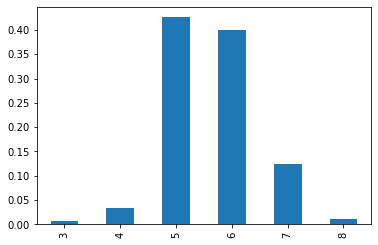

In [4]:
wine_quality = df.label.value_counts(normalize=True)
wine_quality = wine_quality.sort_index()
wine_quality.plot(kind="bar")

In [5]:
def transform_label(value):
    if value <= 5:
        return "bad"
    else:
        return "good"

df["label"] = df.label.apply(transform_label)


good    0.534709
bad     0.465291
Name: label, dtype: float64

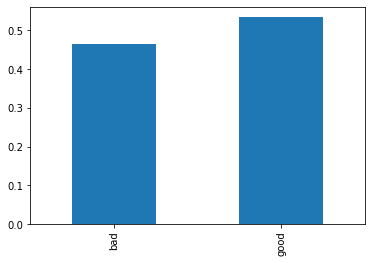

In [6]:
wine_quality = df.label.value_counts(normalize=True)
wine_quality[["bad", "good"]].plot(kind="bar")
wine_quality

In [7]:
random.seed(0)
train_df, test_df = train_test_split(df, test_size=0.2)


<h3>Random Forest ( случ. лес)</h3> — это множество решающих деревьев. В задаче регрессии их ответы усредняются, в задаче классификации принимается решение голосованием по большинству. <b id="18">Заниженный bias, усреднение помоагет понизить еще и variance.</b>

$$\text{BAGGING } + \text{ RSM(Random subspace method) } + \text{ Decision trees} = \text{ Random Forest}$$

Идея: вот у нас есть <b>BAGGING</b>, давайте добавим случайности в наши деревья еще больше, чтобы ошибки были еще больше нескоррелированы. Применяем RSM метод:  метод обучения ансамбля, который пытается уменьшить корреляцию между деревьями в ансамбле, обучая их на случайных выборках фичей вместо всего набора фичей.

Основные параметры: 

<b>Число деревьев — n_estimators</b> 

Чем больше деревьев, тем лучше качество, но время настройки и работы RF также пропорционально увеличиваются. Часто при увеличении n_estimators качество на обучающей выборке повышается (может даже доходить до 100%), а качество на тесте выходит на асимптоту (можно прикинуть).

<b>Максимальная глубина деревьев — max_depth</b> 

Чем меньше глубина, тем быстрее строится и работает RF. При увеличении глубины резко возрастает качество на обучении, но и на тесте оно, как правило, увеличивается. Рекомендуется использовать максимальную глубину (кроме случаев, когда оч много выбросов). 

<b>Число признаков для выбора расщепления — max_features</b>

При увеличении max_features увеличивается время построения леса, а деревья становятся «более однообразными». По умолчанию он равен sqrt(n) в задачах классификации и n/3 в задачах регрессии. Это самый важный параметр! Его настраивают в первую очередь (при достаточном числе деревьев в лесе).

<b>Минимальное число объектов, при котором выполняется расщепление  - min_samples_split</b>

При увеличении параметра качество на обучении падает, а время построения RF сокращается.

Для оценки можно использовать сам train - метод оценки OOB = out of back. (из-за того что выборки методом bootstrapa)

In [8]:
# 1.генерируем бутстрапированные выборки
def bootstraping(train_df, n_bootstrap):
    # выбор с возвращением
    bootstrap_indices = np.random.randint(low=0, high=len(train_df), size=n_bootstrap)
    df_bootstraped = train_df.iloc[bootstrap_indices]
    
    return df_bootstraped

In [9]:
bootstraping(train_df, 3)

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,label
1496,7.7,0.54,0.26,1.9,0.089,23.0,147.0,0.99636,3.26,0.59,9.7,bad
1303,8.0,0.28,0.44,1.8,0.081,28.0,68.0,0.99501,3.36,0.66,11.2,bad
11,7.5,0.50,0.36,6.1,0.071,17.0,102.0,0.99780,3.35,0.80,10.5,bad


In [10]:
# 2. RSM - обучаем датасеты только на рандомном кол-ве фичей

def get_potential_splits(data, random_subspace):
    
    potential_splits = {}
    _, n_columns = data.shape
    column_indices = list(range(n_columns - 1)) # все фичи минус лэйбл
    
    if random_subspace and random_subspace <= len(column_indices): 
        # Chooses k unique random elements from a population
        column_indices = random.sample(population=column_indices, k=random_subspace)
    
    
    for column_index in column_indices:  
        values = data[:, column_index]
        unique_values = np.unique(values)
        
        potential_splits[column_index] = unique_values
    
    return potential_splits

In [11]:
get_potential_splits(train_df.values, random_subspace=2)

{8: array([2.86, 2.87, 2.89, 2.9, 2.92, 2.93, 2.94, 2.95, 2.98, 2.99, 3.0,
        3.01, 3.02, 3.03, 3.04, 3.05, 3.06, 3.07, 3.08, 3.09, 3.1, 3.11,
        3.12, 3.13, 3.14, 3.15, 3.16, 3.17, 3.18, 3.19, 3.2, 3.21, 3.22,
        3.23, 3.24, 3.25, 3.26, 3.27, 3.28, 3.29, 3.3, 3.31, 3.32, 3.33,
        3.34, 3.35, 3.36, 3.37, 3.38, 3.39, 3.4, 3.41, 3.42, 3.43, 3.44,
        3.45, 3.46, 3.47, 3.48, 3.49, 3.5, 3.51, 3.52, 3.53, 3.54, 3.55,
        3.56, 3.57, 3.58, 3.59, 3.6, 3.61, 3.62, 3.63, 3.66, 3.67, 3.68,
        3.69, 3.71, 3.72, 3.74, 3.75, 3.78, 3.9, 4.01], dtype=object),
 5: array([1.0, 2.0, 3.0, 4.0, 5.0, 5.5, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0,
        13.0, 14.0, 15.0, 16.0, 17.0, 18.0, 19.0, 20.0, 21.0, 22.0, 23.0,
        24.0, 25.0, 26.0, 27.0, 28.0, 29.0, 30.0, 31.0, 32.0, 33.0, 34.0,
        35.0, 36.0, 37.0, 37.5, 38.0, 39.0, 40.0, 40.5, 41.0, 42.0, 43.0,
        45.0, 46.0, 47.0, 48.0, 50.0, 51.0, 52.0, 53.0, 54.0, 55.0, 66.0,
        68.0, 72.0], dtype=object)}

In [12]:
# 3. RF algorithm
def random_forest_algorithm(train_df, n_trees, n_bootstrap, n_features, dt_max_depth):
    """
    ######################   PARAMETERS    ######################
    
    train_df: dataset
    
    n_trees: кол-во деревьев
    
    n_bootstrap: размер бутстрапированных датасетов
    
    n_features: на скольких фичах обучаем 
    
    dt_max_depth: максимальная глубина деревьев
    
    #############################################################
    """
    forest = [] 
    
    for i in range(n_trees):
        df_bootstrapped = bootstraping(train_df, n_bootstrap)
        tree = decision_tree_algorithm(df_bootstrapped, max_depth=dt_max_depth, random_subspace=n_features)
        forest.append(tree)
    
       
    
    return forest # list contains all of the trees

In [13]:
forest = random_forest_algorithm(train_df, n_trees=4, n_bootstrap=800, n_features=4, dt_max_depth=4)

In [15]:
len(forest)

4

In [28]:
# 4. predictions for RF

def random_forest_predictions(test_df, forest):
    df_predictions = {}

    for i in range(len(forest)):
        column_name = 'tree_{}'.format(i)
        predictions = decision_tree_predictions(test_df, tree=forest[i])
        df_predictions[column_name] = predictions

    df_predictions = pd.DataFrame(df_predictions)
    random_forest_predictions = df_predictions.mode(axis=1)[0]
    
    
    return random_forest_predictions

In [29]:
predictions = random_forest_predictions(test_df, forest)

In [30]:
accuracy = calculate_accuracy(predictions, test_df.label)
accuracy

0.73125

In [32]:
forest = random_forest_algorithm(train_df, n_trees=2, n_bootstrap=len(train_df), n_features=999, dt_max_depth=4)
predictions = random_forest_predictions(test_df, forest)
accuracy = calculate_accuracy(predictions, test_df.label)
accuracy

0.728125

In [35]:
accuracies = []
for i in range(10):
    forest = random_forest_algorithm(train_df, n_trees=4, n_bootstrap=800, n_features=4, dt_max_depth=4)
    predictions = random_forest_predictions(test_df, forest)
    accuracy = calculate_accuracy(predictions, test_df.label)
    print(accuracy)
    accuracies.append(accuracy)

print('average accuracy: {}'.format(np.array(accuracies).mean()))

0.75
0.746875
0.728125
0.734375
0.746875
0.7625
0.734375
0.734375
0.740625
0.73125
average accuracy: 0.7409375


In [36]:
accuracies = []
for i in range(10):
    forest = random_forest_algorithm(train_df, n_trees=1, n_bootstrap=len(train_df), n_features=999, dt_max_depth=4)
    predictions = random_forest_predictions(test_df, forest)
    accuracy = calculate_accuracy(predictions, test_df.label)
    print(accuracy)
    accuracies.append(accuracy)

print('average accuracy: {}'.format(np.array(accuracies).mean()))

0.75
0.6875
0.73125
0.715625
0.725
0.728125
0.721875
0.684375
0.715625
0.715625
average accuracy: 0.7175
